In [1]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tqdm import tqdm

N_STEPS = 3
N_FEATURES = 1
PRED_DAYS = 8

In [2]:
def splitSequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
def readData(tableName,columnName):
    date_csv = pd.read_csv(tableName)
    dataset = date_csv[columnName].values
    dataset = dataset.astype('float32')
    maxValue = np.max(dataset)  # 获得最大值
    minValue = np.min(dataset)
    scalar = maxValue - minValue  # 获得间隔数量
    #dataset = list(map(lambda x: (x - minValue) / scalar, dataset))
    return dataset

In [4]:
def normalizeData(dataset):
    maxValue = np.max(dataset)  # 获得最大值
    minValue = np.min(dataset)
    scalar = maxValue - minValue  # 获得间隔数量
    dataset = list(map(lambda x: (x - minValue) / scalar, dataset))
    return dataset, scalar, minValue

In [5]:
def getTrainAndTest(dataset):
    X_all, y_all = splitSequence(dataset, N_STEPS)
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], N_FEATURES))
    train_size = 220
    test_size = len(X_all) - train_size

    # Check the size of test data
    print(test_size)
    
    X_train = X_all[:train_size]
    y_train = y_all[:train_size]
    X_test = X_all[train_size:]
    y_test = y_all[train_size:]
    return X_train, y_train, X_test, y_test

In [6]:
def trainAndPred(X_train, y_train, X_test):
    modelDouble = Sequential()
    modelDouble.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(N_STEPS, N_FEATURES)))
    modelDouble.add(Dense(1))
    modelDouble.compile(optimizer='adam', loss='mse')
    callback = EarlyStopping(monitor='loss', patience=10)
    modelDouble.fit(X_train, y_train, epochs=1500, verbose=0, callbacks=[callback], batch_size=5)
    x_input = X_test

    # Check the size of test data
    print(x_input.shape)
    
    x_input = x_input.reshape((PRED_DAYS, N_STEPS, N_FEATURES))
    yhat = modelDouble.predict(x_input, verbose=0)
    return yhat

In [7]:
def returnNormal(scalar, minValue, y_hat, y_test):
    pred_y = list(map(lambda x: x * scalar + minValue, y_hat))
    real_y = list(map(lambda x: x * scalar + minValue, y_test))
    return pred_y, real_y

In [8]:
def emdLSTM(dataset):
    emd = EMD()
    IMFs = emd.emd(dataset)
    print(type(IMFs))
    [rows, columns] = IMFs.shape
    yhatResult = 0
    for n, imf in enumerate(IMFs):
        tempDataSet = imf
        #print('--------------------------------------')
        #myDataSet, myScalar, myMinValue = normalizeData(tempDataSet)
        X_train, y_train, X_test, y_test = getTrainAndTest(tempDataSet)
        yhat = trainAndPred(X_train, y_train, X_test)
        #pred_y, _ = returnNormal(myScalar, myMinValue, yhat, y_test)
        #print(yhat)
        yhatResult = yhat + yhatResult
    print(yhatResult)
    return yhatResult

In [9]:
def metrics(test,predict):
    # MSE均方误差,越小越好
    mse = mean_squared_error(test, predict)
    print("MSE=", mse)

    # MAE数值越小越好，可以通过对比判断好坏
    mae = mean_absolute_error(test, predict)
    print("MAE=", mae)

    # R平方值，越接近1越好
    r2 = r2_score(test, predict)
    print("R_square=", r2)

In [10]:
dataset = readData('../data/0226_mean_yingkou_qinzhou.csv', 'size')
dataset.shape

(231,)

In [11]:
_, _, _, y_test = getTrainAndTest(dataset)

8


In [12]:
yhat = emdLSTM(dataset)

<class 'numpy.ndarray'>
8
(8, 3, 1)
8
(8, 3, 1)
8
(8, 3, 1)
8
(8, 3, 1)
8
(8, 3, 1)
8
(8, 3, 1)
8
(8, 3, 1)
[[ 20.23843  ]
 [-11.425969 ]
 [ 84.56971  ]
 [ 25.806858 ]
 [152.67393  ]
 [ 40.612606 ]
 [ 60.490356 ]
 [ 15.0760145]]


In [13]:
metrics(y_test, yhat)

MSE= 3542.2883
MAE= 45.211487
R_square= -0.16697788036271888


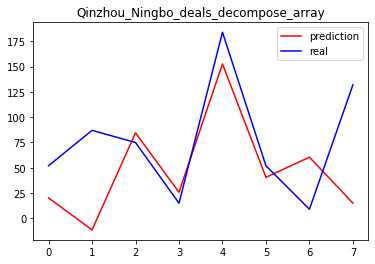

In [14]:
plt.title('Qinzhou_Ningbo_deals_decompose_array')
plt.plot(yhat, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.legend(loc='best')
plt.savefig('Qinzhou_Ningbo_deals_decompose_array.png')
plt.show()